# Robots are smart… by design !!

Who make those Robots smart? Its you Machine Learning guys !
In this project, our task is to help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

Hope you guys will learn something from this sensor data. Its kind of IOT data, as in IOT, we usually work with sensor data..  

## Its a golden chance to help humanity, by helping Robots !

In [14]:
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

#from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [38]:
tr = pd.read_csv('X_trainnn.csv')
te = pd.read_csv('X_testtt.csv')
target = pd.read_csv('y_train.csv')
ss = pd.read_csv('sample_submission.csv')

In [39]:
ss = pd.read_csv('sample_submission.csv')
target = pd.read_csv('y_train.csv')

In [40]:
sub = pd.read_csv('sample_submission.csv')

In [41]:
tr.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [19]:
tr.shape, te.shape

((487680, 13), (488448, 13))

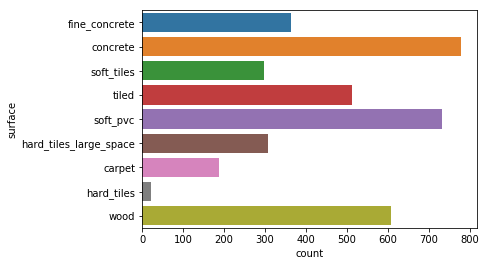

In [20]:
countplot(y = 'surface', data = target)
plt.show()

We need to classify on which surface our robot is standing.

So, its a simple classification task. Multi-class to be specific.

In [21]:
len(tr.measurement_number.value_counts())

128

What's that?
Each series has 128 measurements. 

In [22]:
tr.shape[0] / 128, te.shape[0] / 128

(3810.0, 3816.0)

So, we have 3810 train series, and 3816 test series.
Let's engineer some features!

## Feature Engineering

In [42]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [43]:
def fe1(actual):
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    actual['norm_X_Y']=(actual['orientation_X']*actual['orientation_X'])/actual['mod_quat']**2
    actual['norm_Y_Z']=(actual['orientation_Y']*actual['orientation_Z'])/actual['mod_quat']**2
    actual['norm_Y_W']=(actual['orientation_Y']*actual['orientation_W'])/actual['mod_quat']**2
    actual['norm_W_X']=(actual['orientation_W']*actual['orientation_X'])/actual['mod_quat']**2
    
    return actual

In [44]:
data = fe1(tr)
test = fe1(te)
print(data.shape)
data.head()

(487680, 23)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,norm_X_Y,norm_Y_Z,norm_Y_W,norm_W_X
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,0.575369,0.066531,0.067222,0.080382
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,0.575371,0.066543,0.067240,0.080405
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,0.575365,0.066556,0.067222,0.080381
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,0.575347,0.066575,0.067223,0.080380
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,0.575356,0.066575,0.067216,0.080373


In [45]:
def fe2(actual):
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [46]:
data = fe1(data)
test = fe1(test)
print (data.shape)
data.head()

(487680, 23)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,norm_X_Y,norm_Y_Z,norm_Y_W,norm_W_X
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,0.575369,0.066531,0.067222,0.080382
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,0.575371,0.066543,0.067240,0.080405
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,0.575365,0.066556,0.067222,0.080381
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,0.575347,0.066575,0.067223,0.080380
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,0.575356,0.066575,0.067216,0.080373


In [47]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z'])** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    data['total_angular_velocity_1'] = ((data['angular_velocity_X']*data['angular_velocity_Y']) ** 2 + (data['angular_velocity_Y']*data['angular_velocity_Z']) ** 2 + (data['angular_velocity_Z']*data['angular_velocity_X'])** 2) ** 0.25
    data['total_linear_acceleration_1'] = ((data['linear_acceleration_X']*data['linear_acceleration_Y'])** 2 + (data['linear_acceleration_Y']*data['linear_acceleration_Z'])** 2 + (data['linear_acceleration_Z']*data['linear_acceleration_X']) ** 2) ** 0.25
    data['acc_vs_vel'] = data['total_linear_acceleration_1'] / data['total_angular_velocity_1']
     #data["acc_cube"]=(data["linear_acceleration_X"]+data["linear_acceleration_Y"]+data["linear_acceleration_Z"])**0.5
     #data["vel_cube"]=(data["angular_velocity_X"]+data["angular_velocity_Y"]+data["angular_velocity_Z"])**0.5
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
         #df[col + '_min'] = data.groupby(['series_id'])[col].skew()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [48]:
tr = feat_eng(data)
te= feat_eng(test)

In [49]:
tr.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_max,orientation_X_abs_min,...,total_linear_acceleration_1_median,total_linear_acceleration_1_max,total_linear_acceleration_1_min,total_linear_acceleration_1_std,total_linear_acceleration_1_range,total_linear_acceleration_1_maxtoMin,total_linear_acceleration_1_mean_abs_chg,total_linear_acceleration_1_abs_max,total_linear_acceleration_1_abs_min,total_linear_acceleration_1_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,0.75953,0.75822,...,5.580801,7.113190,1.109889,1.226807,6.003301,6.408921,0.482781,7.113190,1.109889,4.111540
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,0.95896,0.95837,...,5.388311,8.176416,0.749493,1.406703,7.426924,10.909267,0.788131,8.176416,0.749493,4.462955
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.51434,0.50944,...,5.395743,7.412167,1.168643,1.462066,6.243524,6.342543,0.572956,7.412167,1.168643,4.290405
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.000026,0.93968,0.93884,...,6.125140,11.254797,1.054612,2.082836,10.200185,10.671977,1.326753,11.254797,1.054612,6.154705
4,-0.891301,-0.890940,-0.88673,-0.89689,0.002955,0.01016,0.988672,0.000080,0.89689,0.88673,...,5.540675,6.734792,1.929055,1.102584,4.805737,3.491239,0.246416,6.734792,1.929055,4.331924


In [50]:
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [51]:
tr.fillna(0, inplace = True)
te.fillna(0, inplace = True)

In [52]:
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)
te.replace(-np.inf, 0, inplace = True)
te.replace(np.inf, 0, inplace = True)

-------------------- 0 --------------------
score  0.8935064935064935


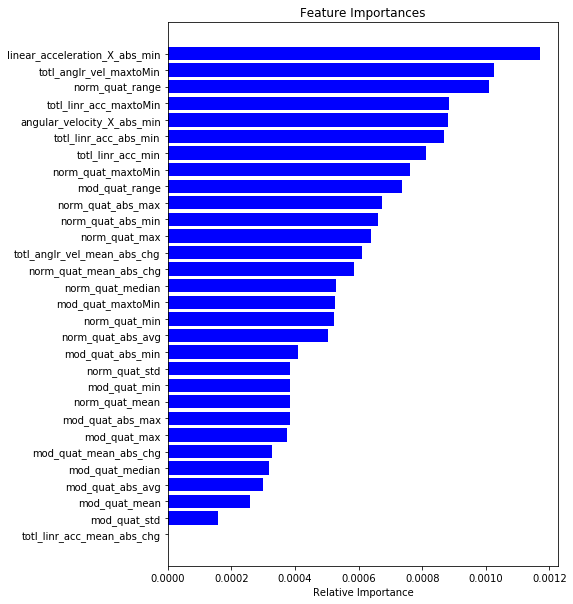

-------------------- 1 --------------------
score  0.9036458333333334


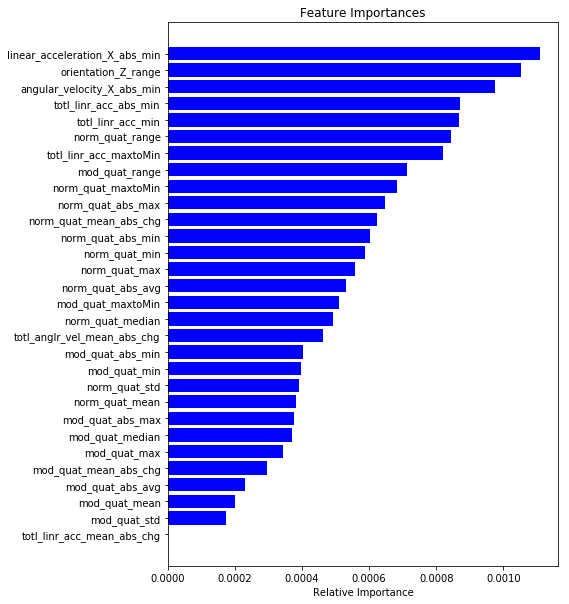

-------------------- 2 --------------------
score  0.8981723237597912


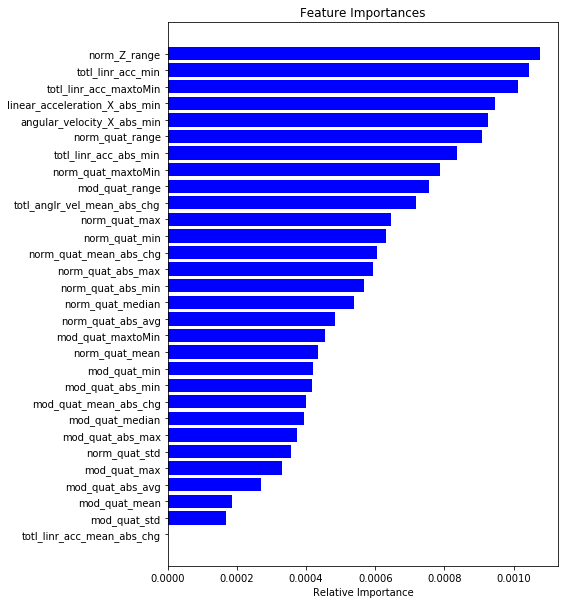

-------------------- 3 --------------------
score  0.8717277486910995


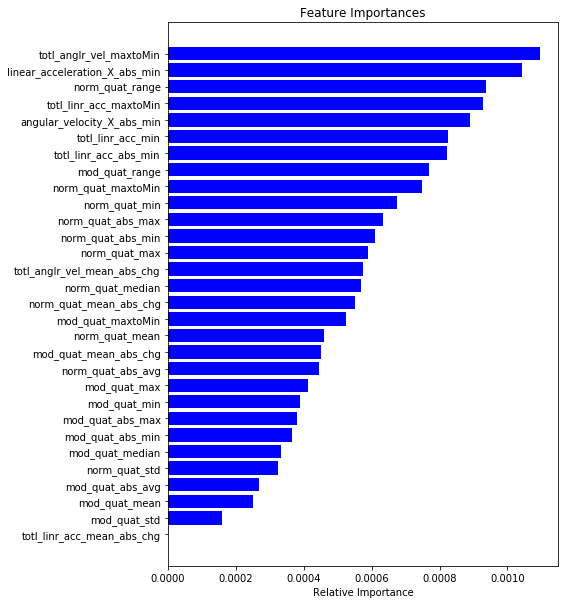

-------------------- 4 --------------------
score  0.8818897637795275


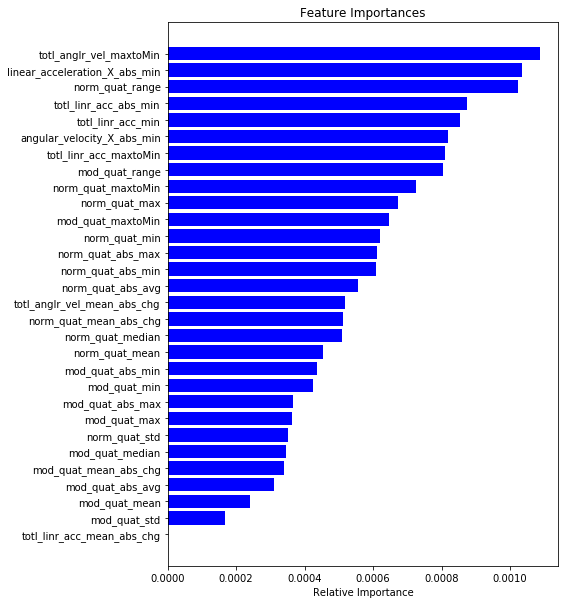

-------------------- 5 --------------------
score  0.8976377952755905


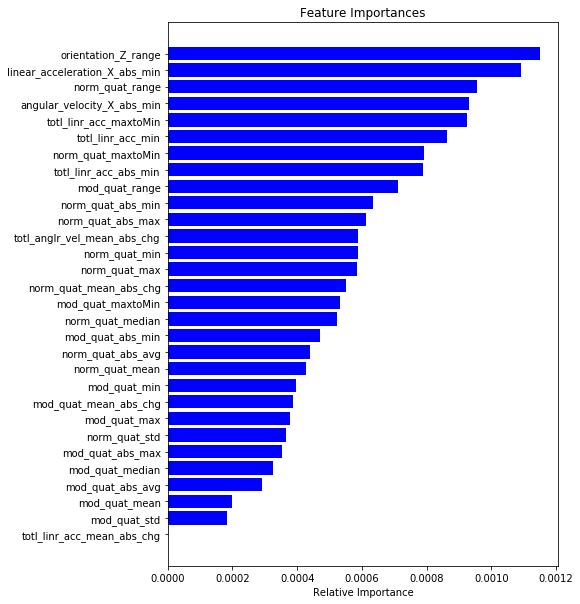

-------------------- 6 --------------------
score  0.8976377952755905


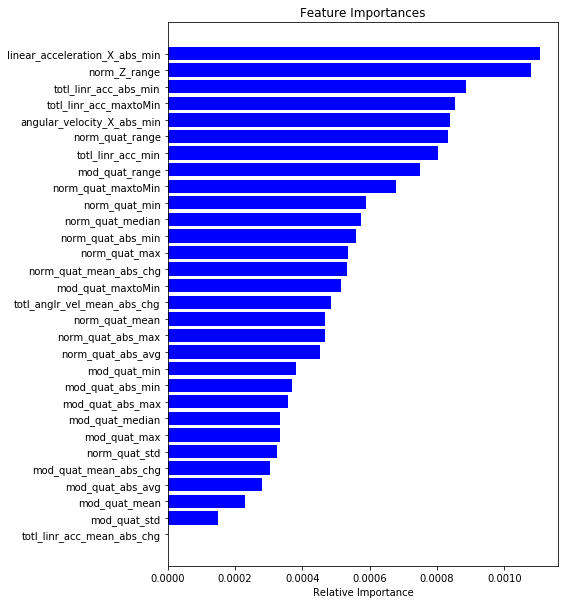

-------------------- 7 --------------------
score  0.8918205804749341


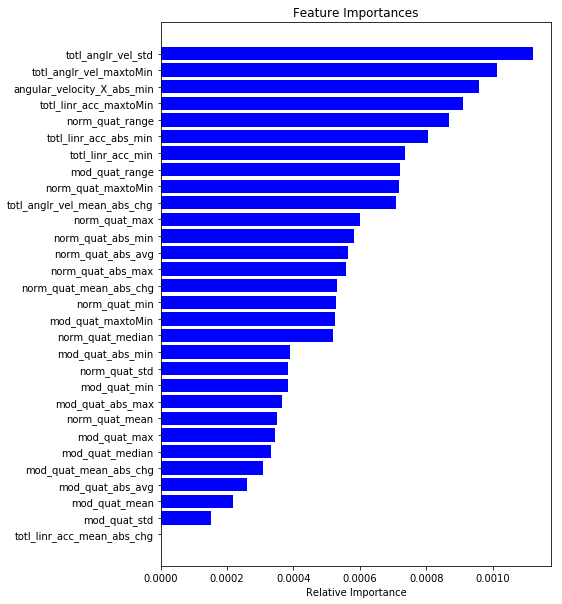

-------------------- 8 --------------------
score  0.917989417989418


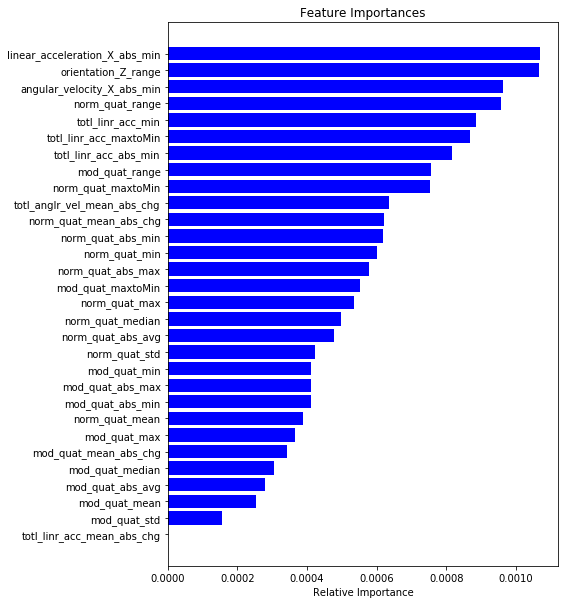

-------------------- 9 --------------------
score  0.8776595744680851


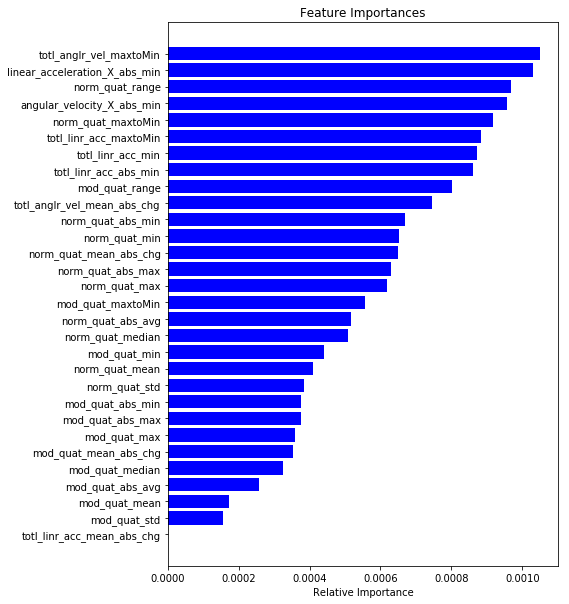

Avg Accuracy 0.8931687326553863


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=54)
sub_preds_rf = np.zeros((te.shape[0], 9))
oof_preds_rf = np.zeros((tr.shape[0]))
score = 0
for i, (train_index, test_index) in enumerate(folds.split(tr, target['surface'])):
    print('-'*20, i, '-'*20)
    
    clf =  RandomForestClassifier(n_estimators =500, n_jobs = -1)
     #clf = GradientBoostingClassifier(n_estimators = 150, random_state=1)
    clf.fit(tr.iloc[train_index], target['surface'][train_index])
    oof_preds_rf[test_index] = clf.predict(tr.iloc[test_index])
    sub_preds_rf += clf.predict_proba(te) / folds.n_splits
    score += clf.score(tr.iloc[test_index], target['surface'][test_index])
    print('score ', clf.score(tr.iloc[test_index], target['surface'][test_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = tr.columns

    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print('Avg Accuracy', score / folds.n_splits)

In [66]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

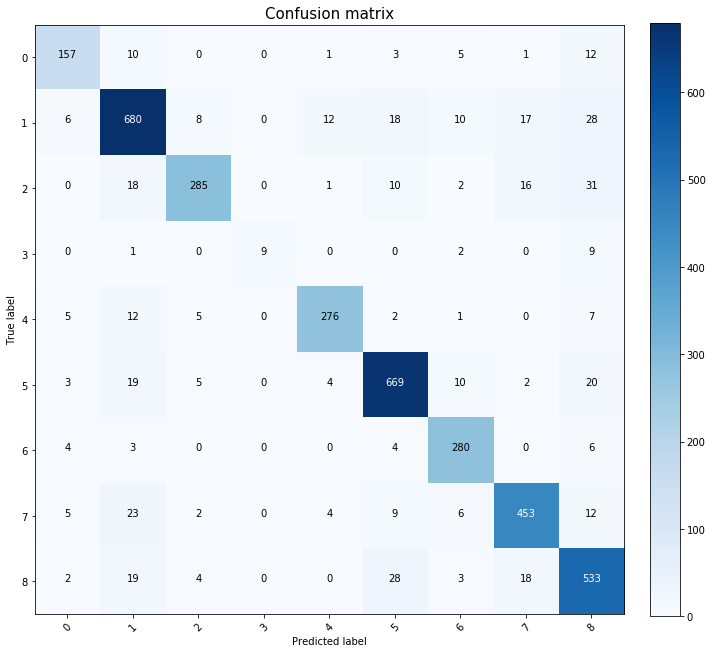

In [67]:
plot_confusion_matrix(target['surface'], oof_preds_rf, le.classes_)

In [54]:
sub['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
sub.to_csv('27marchsubmission3.csv', index=False)
sub.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles
